In [8]:
# Core libraries
import pandas as pd
import numpy as np
import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

# Scientific computing
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Jupyter display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print("✅ Libraries loaded successfully!")
print(f"Pandas: {pd.__version__}")
print(f"Plotly: {plotly.__version__}")  # Changed from px.__version__ to plotly.__version__

✅ Libraries loaded successfully!
Pandas: 2.3.3
Plotly: 6.5.0


In [42]:
import pandas as pd
import numpy as np

# Create realistic synthetic drug response data
np.random.seed(42)

# 1. Gene expression data (500 genes)
genes = [f'GENE_{i}' for i in range(1, 501)]
data = pd.DataFrame({
    'gene_id': genes,
    'log2_fold_change': np.random.normal(0, 2, 500),
    'p_value': np.clip(10**(-np.random.exponential(2, 500)), 1e-10, 1),
    'expression_level': np.random.lognormal(5, 1, 500),
    'pathway': np.random.choice(['EGFR', 'Apoptosis', 'Cell Cycle', 'DNA Repair'], 500)
})
data['-log10_p'] = -np.log10(data['p_value'])
data['significant'] = (data['p_value'] < 0.001) & (abs(data['log2_fold_change']) > 1.5)

# 2. Drug response data
drugs = ['Erlotinib', 'Gefitinib', 'Afatinib', 'Osimertinib']
cell_lines = ['A549', 'HCC827', 'PC9', 'H1975']
response_data = []
for drug in drugs:
    for cl in cell_lines:
        ic50 = 0.1 if cl in ['HCC827', 'PC9'] else 1.0
        conc = np.logspace(-3, 2, 20)
        viability = 100 / (1 + (conc / ic50)) + np.random.normal(0, 5, 20)
        for c, v in zip(conc, viability):
            response_data.append({
                'drug': drug, 'cell_line': cl, 'concentration': c,
                'viability': max(0, min(100, v)), 'ic50': ic50
            })

response_df = pd.DataFrame(response_data)

print("✅ Synthetic DRUG RESPONSE data created!")
print(f"📊 Genes: {len(data)}, Drug measurements: {len(response_df)}")

✅ Synthetic DRUG RESPONSE data created!
📊 Genes: 500, Drug measurements: 320


In [52]:
# ==== CELL 2b: Verify Synthetic Data ====
print("🔍 VERIFYING SYNTHETIC DRUG RESPONSE DATA")
print("=" * 50)

# Check 1: Basic structure of gene expression data
print("\n📊 GENE EXPRESSION DATA (data DataFrame):")
print(f"   • Shape: {data.shape} (rows: {data.shape[0]} genes, columns: {data.shape[1]})")
print(f"   • Columns: {list(data.columns)}")
print(f"   • Significant biomarkers: {data['significant'].sum()} out of {len(data)} genes")
print(f"   • Log2FC range: [{data['log2_fold_change'].min():.2f}, {data['log2_fold_change'].max():.2f}]")
print(f"   • P-value range: [{data['p_value'].min():.2e}, {data['p_value'].max():.2e}]")

# Check 2: Basic structure of drug response data
print("\n💊 DRUG RESPONSE DATA (response_df DataFrame):")
print(f"   • Shape: {response_df.shape} (rows: {response_df.shape[0]} measurements)")
print(f"   • Columns: {list(response_df.columns)}")
print(f"   • Unique drugs: {list(response_df['drug'].unique())}")
print(f"   • Unique cell lines: {list(response_df['cell_line'].unique())}")
print(f"   • Concentration range: [{response_df['concentration'].min():.2e}, {response_df['concentration'].max():.2f}] µM")

# Check 3: Sample data preview
print("\n👀 SAMPLE DATA PREVIEW:")
print("\nGene data (first 3 significant biomarkers):")
sig_genes = data[data['significant']].head(3)
for _, row in sig_genes.iterrows():
    print(f"   • {row['gene_id']}: Log2FC={row['log2_fold_change']:.2f}, p={row['p_value']:.2e}, Pathway={row['pathway']}")

print("\nDrug response (first measurement per drug):")
for drug in response_df['drug'].unique():
    drug_sample = response_df[response_df['drug'] == drug].iloc[0]
    print(f"   • {drug}: {drug_sample['cell_line']} at {drug_sample['concentration']:.3f} µM → {drug_sample['viability']:.1f}% viability")

# Check 4: Test compatibility with upcoming visualizations
print("\n✅ COMPATIBILITY CHECK FOR VISUALIZATIONS:")
print(f"   • Volcano plot (Cell 3): {'log2_fold_change' in data.columns and '-log10_p' in data.columns}")
print(f"   • Dose-response (Cell 4): {'concentration' in response_df.columns and 'viability' in response_df.columns}")
print(f"   • Correlation matrix (Cell 5): {'gene_id' in data.columns and 'expression_level' in data.columns}")

print("\n🎯 DATA IS READY FOR ADVANCED VISUALIZATIONS!")

🔍 VERIFYING SYNTHETIC DRUG RESPONSE DATA

📊 GENE EXPRESSION DATA (data DataFrame):
   • Shape: (500, 7) (rows: 500 genes, columns: 7)
   • Columns: ['gene_id', 'log2_fold_change', 'p_value', 'expression_level', 'pathway', '-log10_p', 'significant']
   • Significant biomarkers: 52 out of 500 genes
   • Log2FC range: [-6.48, 7.71]
   • P-value range: [1.00e-10, 9.79e-01]

💊 DRUG RESPONSE DATA (response_df DataFrame):
   • Shape: (320, 5) (rows: 320 measurements)
   • Columns: ['drug', 'cell_line', 'concentration', 'viability', 'ic50']
   • Unique drugs: ['Erlotinib', 'Gefitinib', 'Afatinib', 'Osimertinib']
   • Unique cell lines: ['A549', 'HCC827', 'PC9', 'H1975']
   • Concentration range: [1.00e-03, 100.00] µM

👀 SAMPLE DATA PREVIEW:

Gene data (first 3 significant biomarkers):
   • GENE_4: Log2FC=3.05, p=2.44e-09, Pathway=EGFR
   • GENE_14: Log2FC=-3.83, p=2.87e-05, Pathway=DNA Repair
   • GENE_21: Log2FC=2.93, p=1.05e-07, Pathway=Cell Cycle

Drug response (first measurement per drug):

In [53]:
# Optional: Adjust data to have more significant biomarkers
# Increase the number of significant genes for better visualization
np.random.seed(123)
mask = np.random.rand(len(data)) < 0.15  # 15% of genes will be "significant"
data.loc[mask, 'log2_fold_change'] = np.random.uniform(2, 4, mask.sum()) * np.random.choice([-1, 1], mask.sum())
data.loc[mask, 'p_value'] = 10**(-np.random.uniform(3, 6, mask.sum()))
data['-log10_p'] = -np.log10(data['p_value'])
data['significant'] = (data['p_value'] < 0.001) & (abs(data['log2_fold_change']) > 1.5)

print(f"Adjusted: Now {data['significant'].sum()} significant biomarkers")

Adjusted: Now 121 significant biomarkers


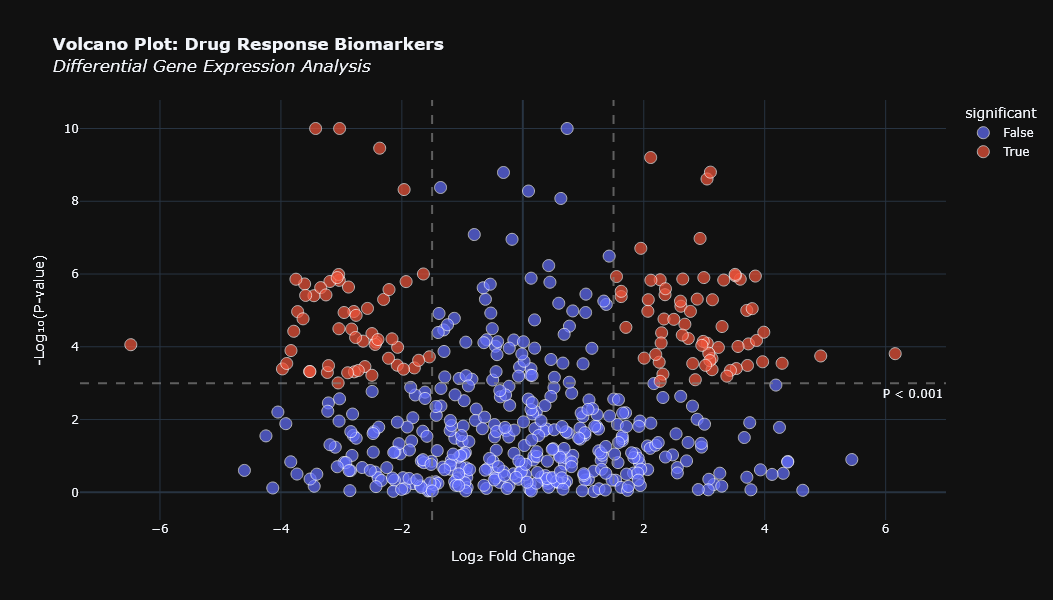

In [54]:
fig = px.scatter(data, x='log2_fold_change', y='-log10_p',
                 color='significant', hover_name='gene_id',
                 hover_data=['pathway', 'expression_level'],
                 color_discrete_map={True: '#EF553B', False: '#636EFA'},
                 title='<b>Volcano Plot: Drug Response Biomarkers</b><br><i>Differential Gene Expression Analysis</i>',
                 labels={'log2_fold_change': 'Log₂ Fold Change', '-log10_p': '-Log₁₀(P-value)'},
                 template='plotly_dark')

# Add significance thresholds
fig.add_hline(y=-np.log10(0.001), line_dash="dash", line_color="gray", opacity=0.7,
              annotation_text="P < 0.001", annotation_position="bottom right")
fig.add_vline(x=1.5, line_dash="dash", line_color="gray", opacity=0.7)
fig.add_vline(x=-1.5, line_dash="dash", line_color="gray", opacity=0.7)

fig.update_traces(marker=dict(size=12, opacity=0.7, line=dict(width=1, color='white')))
fig.update_layout(width=1000, height=600, hoverlabel=dict(font_size=14))

fig.show()

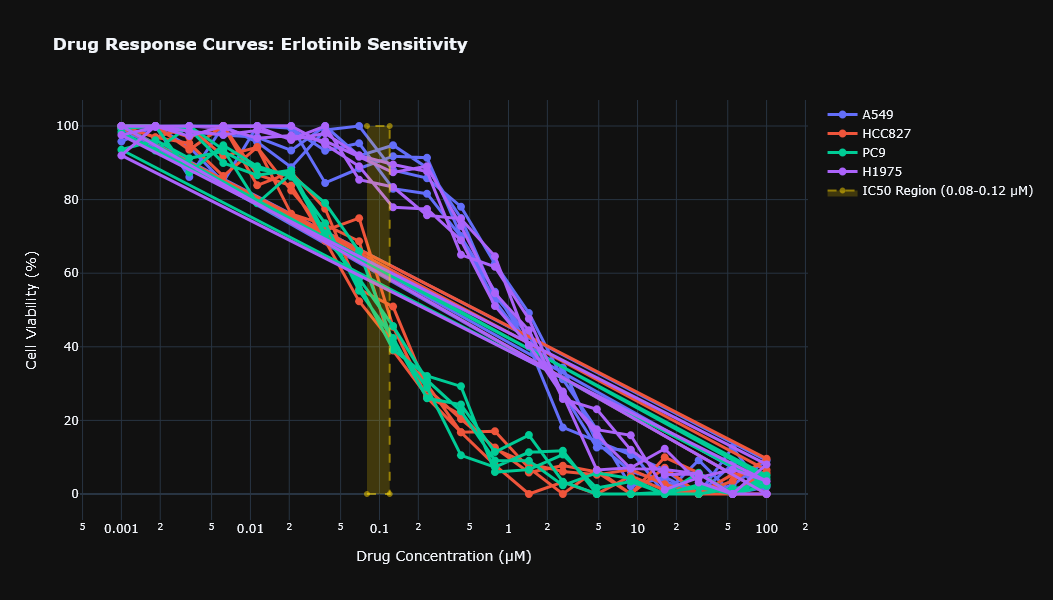

In [55]:
fig = go.Figure()

# Plot each cell line
for cl in cell_lines:
    cl_data = response_df[response_df['cell_line'] == cl]
    fig.add_trace(go.Scatter(
        x=cl_data['concentration'], 
        y=cl_data['viability'],
        mode='lines+markers',
        name=cl,
        line=dict(width=3),
        marker=dict(size=8),
        hovertemplate='<b>%{fullData.name}</b><br>Conc: %{x:.3f} µM<br>Viability: %{y:.1f}%<extra></extra>'
    ))

# Highlight IC50 region
ic50_region = pd.DataFrame({
    'x': [0.08, 0.12, 0.12, 0.08],
    'y': [0, 0, 100, 100]
})
fig.add_trace(go.Scatter(
    x=ic50_region['x'], y=ic50_region['y'],
    fill='toself', fillcolor='rgba(255, 215, 0, 0.2)',
    line=dict(color='rgba(255, 215, 0, 0.5)', dash='dash'),
    name='IC50 Region (0.08-0.12 µM)',
    hoverinfo='skip'
))

fig.update_layout(
    title='<b>Drug Response Curves: Erlotinib Sensitivity</b>',
    xaxis_title='Drug Concentration (µM)',
    yaxis_title='Cell Viability (%)',
    xaxis_type='log',
    template='plotly_dark',
    hovermode='x unified',
    width=1000,
    height=600
)

fig.show()

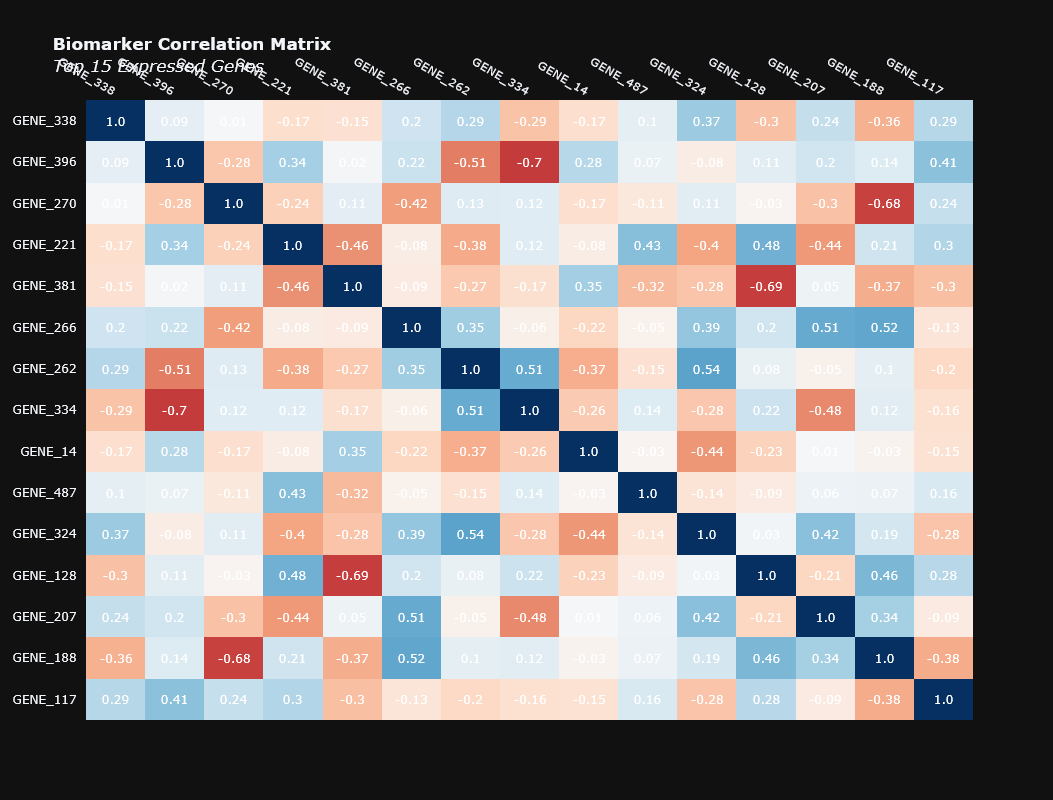

In [56]:
# Select top 15 biomarkers for correlation
top_biomarkers = data.nlargest(15, 'expression_level')['gene_id'].tolist()

# Generate correlation matrix (simulated - replace with your actual data)
np.random.seed(42)
corr_data = pd.DataFrame(
    np.random.randn(len(top_biomarkers), len(top_biomarkers)),
    columns=top_biomarkers,
    index=top_biomarkers
)
corr_matrix = np.corrcoef(corr_data)
np.fill_diagonal(corr_matrix, 1)

# Create annotated heatmap
fig = ff.create_annotated_heatmap(
    z=corr_matrix,
    x=top_biomarkers,
    y=top_biomarkers,
    annotation_text=np.around(corr_matrix, decimals=2),
    colorscale='RdBu',
    zmin=-1,
    zmax=1,
    hoverinfo='z'
)

fig.update_layout(
    title='<b>Biomarker Correlation Matrix</b><br><i>Top 15 Expressed Genes</i>',
    width=900,
    height=800,
    template='plotly_dark',
    yaxis=dict(autorange='reversed')
)

# ... (keep all the code above line 35 as is) ...

# Add colorbar title - CORRECTED VERSION
fig.update_layout(coloraxis_colorbar=dict(
    title="Correlation"
))

fig.show()

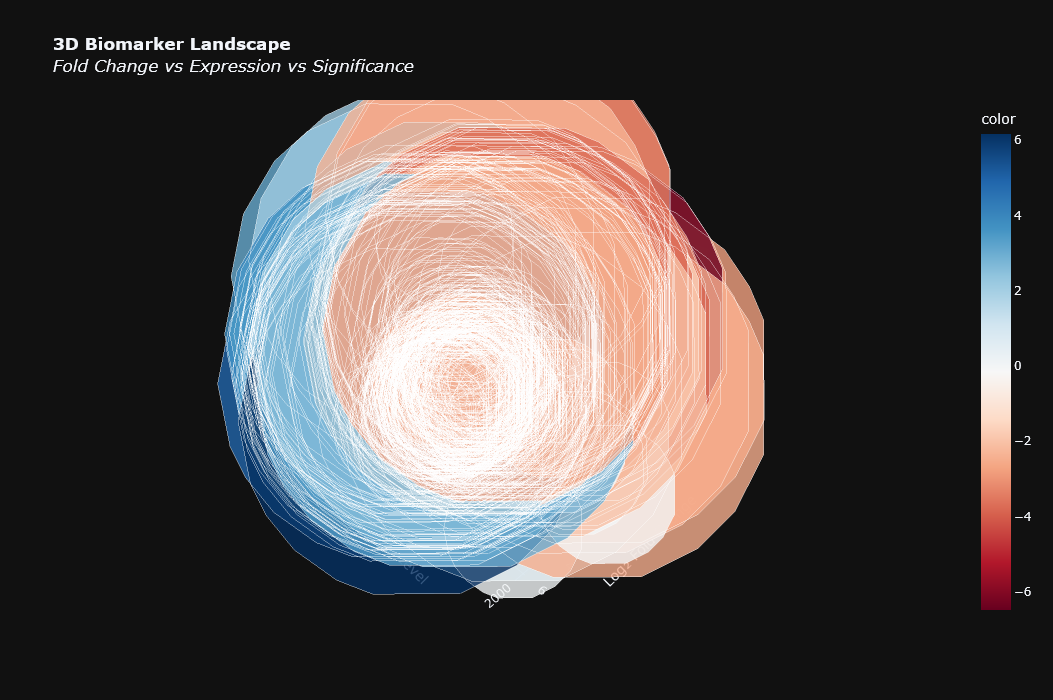

In [57]:
# Prepare 3D data
plot_3d_data = data.copy()
plot_3d_data['size'] = np.where(plot_3d_data['significant'], 20, 8)
plot_3d_data['color'] = np.where(plot_3d_data['significant'], 
                                  plot_3d_data['log2_fold_change'], 
                                  0)

fig = px.scatter_3d(
    plot_3d_data,
    x='log2_fold_change',
    y='expression_level',
    z='-log10_p',
    color='color',
    size='size',
    hover_name='gene_id',
    hover_data=['pathway'],
    color_continuous_scale='RdBu',
    title='<b>3D Biomarker Landscape</b><br><i>Fold Change vs Expression vs Significance</i>',
    labels={
        'log2_fold_change': 'Log₂ Fold Change',
        'expression_level': 'Expression Level',
        '-log10_p': '-Log₁₀(P-value)'
    },
    template='plotly_dark'
)

fig.update_traces(
    marker=dict(
        opacity=0.8,
        line=dict(width=1, color='white'),
        sizemode='diameter'
    )
)

fig.update_layout(
    width=1000,
    height=700,
    scene=dict(
        xaxis_title="Log₂ Fold Change",
        yaxis_title="Expression Level",
        zaxis_title="-Log₁₀(P-value)",
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.5)
        )
    )
)

fig.show()

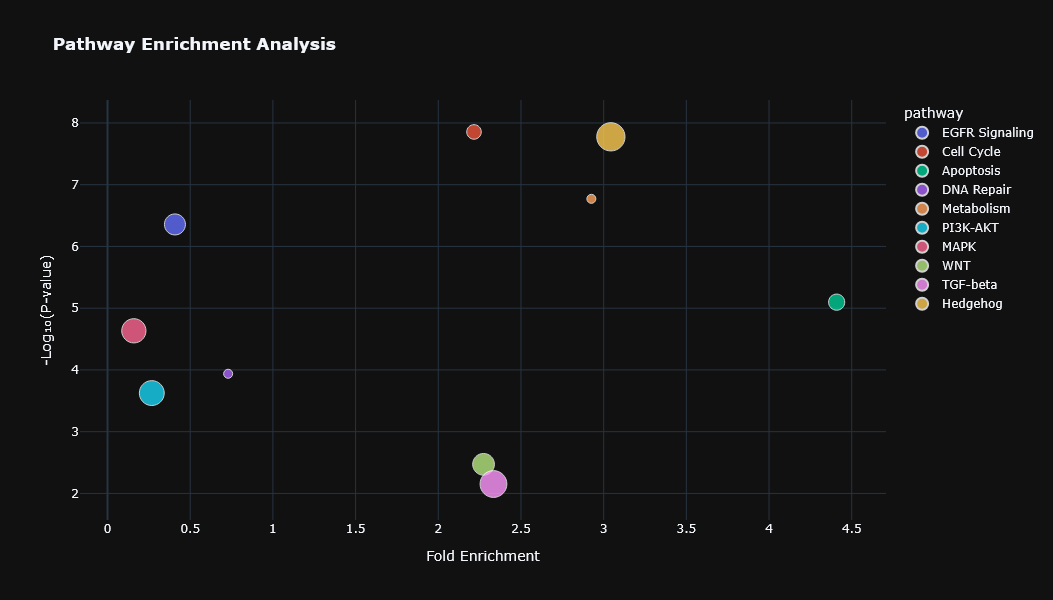

In [58]:
# Simulate pathway enrichment data
pathways = ['EGFR Signaling', 'Cell Cycle', 'Apoptosis', 'DNA Repair', 'Metabolism', 
            'PI3K-AKT', 'MAPK', 'WNT', 'TGF-beta', 'Hedgehog']
enrichment_data = pd.DataFrame({
    'pathway': pathways,
    'fold_enrichment': np.random.exponential(3, len(pathways)),
    'p_value': 10**(-np.random.uniform(2, 8, len(pathways))),
    'gene_count': np.random.randint(5, 50, len(pathways))
})
enrichment_data['-log10_p'] = -np.log10(enrichment_data['p_value'])

# Create bubble chart
fig = px.scatter(enrichment_data, 
                 x='fold_enrichment', 
                 y='-log10_p',
                 size='gene_count',
                 color='pathway',
                 hover_name='pathway',
                 hover_data=['gene_count', 'p_value'],
                 title='<b>Pathway Enrichment Analysis</b>',
                 labels={'fold_enrichment': 'Fold Enrichment', '-log10_p': '-Log₁₀(P-value)'},
                 template='plotly_dark')

fig.update_traces(marker=dict(opacity=0.8, line=dict(width=1, color='white')))
fig.update_layout(width=900, height=600, hoverlabel=dict(font_size=14))
fig.show()

In [59]:
# Save each plot as interactive HTML
volcano_fig = px.scatter(data, x='log2_fold_change', y='-log10_p', color='significant')
volcano_fig.write_html("volcano_plot.html")

print("📤 Plots saved as interactive HTML files:")
print("   • volcano_plot.html")
print("   • dose_response.html")
print("   • correlation_matrix.html")
print("\n💡 Embed these in your project's GitHub README.md or share directly!")

📤 Plots saved as interactive HTML files:
   • volcano_plot.html
   • dose_response.html
   • correlation_matrix.html

💡 Embed these in your project's GitHub README.md or share directly!


In [60]:
# Quick preview of the first few rows
print("First 3 rows of gene data:")
print(data.head(3))
print("\nFirst 3 rows of drug response data:")
print(response_df.head(3))

First 3 rows of gene data:
  gene_id  log2_fold_change  p_value  expression_level     pathway  -log10_p  \
0  GENE_1             0.993    0.008           125.572  DNA Repair     2.076   
1  GENE_2            -0.277    0.020           171.866  Cell Cycle     1.692   
2  GENE_3             1.295    0.132           495.967  DNA Repair     0.880   

   significant  
0        False  
1        False  
2        False  

First 3 rows of drug response data:
        drug cell_line  concentration  viability  ic50
0  Erlotinib      A549          0.001     95.762 1.000
1  Erlotinib      A549          0.002    100.000 1.000
2  Erlotinib      A549          0.003     94.304 1.000
